In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D # Added GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image # Import for image preprocessing in prediction

In [5]:
# --- 1. Data Splitting ---
# Define the source directory for your ASL alphabet images
# IMPORTANT: Replace this path with the actual path to your dataset if it's different.
# Example: train_src = 'path/to/your/asl_alphabet_train'
train_src = r'E:\sanju\asl_alphabet_train\asl_alphabet_train' # User's original path

# Define the output directory for the split datasets
output_dir = "datasets/asl_alphabets"

# Split dataset into training, validation, and test sets
# Ratio: 80% train, 10% validation, 10% test
# seed: for reproducibility of the split
# move: If False, copies files; if True, moves files. Copying is safer.
print(f"Splitting data from {train_src} to {output_dir}...")
splitfolders.ratio(train_src, output=output_dir, seed=1337, ratio=(.8, .1, .1), move=False)
print("Data splitting complete.")


Splitting data from E:\sanju\asl_alphabet_train\asl_alphabet_train to datasets/asl_alphabets...

































Copying files: 36755 files [02:17, 266.39 files/s]




















































































































































































































































































































































































































































































































































































































































































































































































Copying files: 87000 files [01:29, 968.33 files/s] 

Data splitting complete.


In [6]:

# --- 2. Data Loading and Augmentation ---
# Define paths for the split datasets
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')


In [14]:

# Define input shape and batch size
input_shape = (32, 32, 1) # Images are 32x32 pixels, 1 channel for grayscale
batch_size = 32

# Data Augmentation for Training Data
# Rescale: Normalize pixel values to [0, 1]
# rotation_range: Randomly rotate images by a certain degree range
# zoom_range: Randomly zoom in/out on images
# width_shift_range/height_shift_range: Randomly shift images horizontally/vertically
# shear_range: Apply shearing transformations
# horizontal_flip: Randomly flip images horizontally (useful for symmetry)
# fill_mode: Strategy for filling in new pixels created by transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest"
)

# No Data Augmentation for Validation and Test Data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
# flow_from_directory: Reads images from subdirectories (each subdirectory is a class)
# target_size: Resizes all images to this size
# color_mode: "grayscale" for single channel images
# class_mode: "categorical" for one-hot encoded labels (multi-class classification)
# shuffle: Shuffle training data, keep validation/test data in order for consistent evaluation
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=input_shape[:2], batch_size=batch_size,
    color_mode="grayscale", class_mode="categorical", shuffle=False
)

# Get class labels and number of classes from the training generator
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(f"Detected {num_classes} classes: {class_labels}")


Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Detected 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [15]:

# --- 3. CNN Architecture (Improved) ---
# Sequential model: layers are added in sequence
model = models.Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(), # Normalize activations of the previous layer
    MaxPooling2D((2, 2)), # Down-sample feature maps
    Dropout(0.2),        # Randomly set a fraction of input units to 0 at each update step to prevent overfitting

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Global Average Pooling Layer - Replaces Flatten and the initial Dense layer
    # This layer computes the average of all values in each feature map,
    # reducing the spatial dimensions to 1x1, which then feeds directly into the output Dense layer.
    GlobalAveragePooling2D(),

    # Output Layer
    # No intermediate Dense layer needed as GAP provides a compact representation
    Dense(num_classes, activation='softmax') # Output layer with softmax for multi-class classification
])

# Display model summary
model.summary()


c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,309 (380.11 KB)

 Trainable params: 96,861 (378.36 KB)

 Non-trainable params: 448 (1.75 KB)

In [18]:

# --- 4. Compile the Model ---
# Optimizer: Adam is a popular choice for its adaptive learning rate capabilities
# Loss: categorical_crossentropy for multi-class classification with one-hot encoded labels
# Metrics: accuracy to monitor performance during training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- 5. Callbacks for Training ---
# ModelCheckpoint: Saves the best model weights based on 'val_accuracy'
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # Save when validation accuracy is maximized
    verbose=1
)

# EarlyStopping: Stops training if 'val_loss' does not improve for 'patience' epochs
# restore_best_weights: Restores the model weights from the epoch with the best monitored quantity
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10, # Increased patience slightly for stability
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduces learning rate when 'val_loss' stops improving
# factor: Factor by which the learning rate will be reduced (new_lr = lr * factor)
# patience: Number of epochs with no improvement after which learning rate will be reduced
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5, # Increased patience slightly
    factor=0.5,
    verbose=1
)

# --- 6. Train the Model ---
print("Starting model training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50, # Increased epochs, EarlyStopping will stop it if needed
    callbacks=[checkpoint, early_stop, reduce_lr]
)
print("Model training complete.")


Starting model training...
Epoch 1/50


c:\Users\ramch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4540 - loss: 1.9216
Epoch 1: val_accuracy improved from -inf to 0.80471, saving model to best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 283s 129ms/step - accuracy: 0.4541 - loss: 1.9213 - val_accuracy: 0.8047 - val_loss: 0.6310 - learning_rate: 0.0010
Epoch 2/50
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8306 - loss: 0.5357
Epoch 2: val_accuracy improved from 0.80471 to 0.87207, saving model to best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 105s 48ms/step - accuracy: 0.8306 - loss: 0.5357 - val_accuracy: 0.8721 - val_loss: 0.4162 - learning_rate: 0.0010
Epoch 3/50
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8775 - loss: 0.3721
Epoch 3: val_accuracy improved from 0.87207 to 0.92644, saving model to best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 201s 93ms/step - accuracy: 0.8775 - loss: 0.3721 - val_accuracy: 0.9264 - val_loss: 0.2193 - learning_rate: 0.0010
Epoch 4/50
2174/2175 ━━━━━━━━━━━━━━━━━━━

Evaluating model on the test set...
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9984 - loss: 0.0052
Test Loss: 0.0052
Test Accuracy: 0.9986


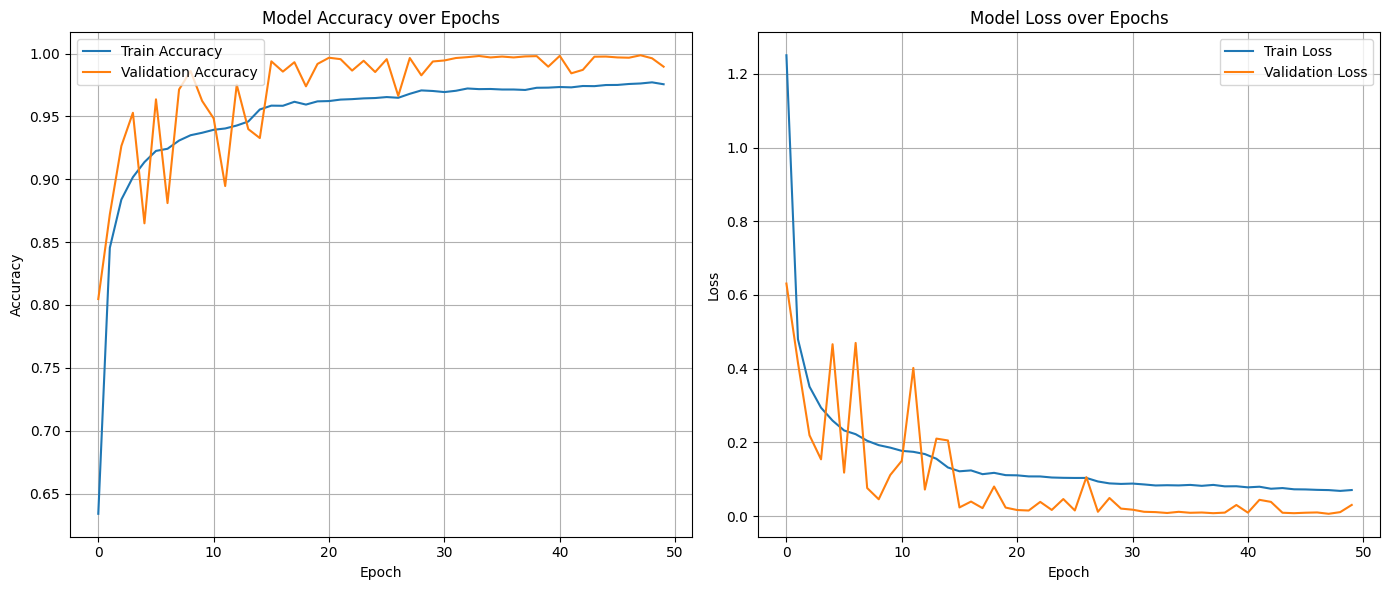

In [21]:

# --- 7. Evaluate the Model on the Test Set ---
print("Evaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- 8. Plotting Learning Curves ---
# Visualize training and validation accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


Predicting for image: C:\Users\ramch\Downloads\H.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted: F (99.99%)


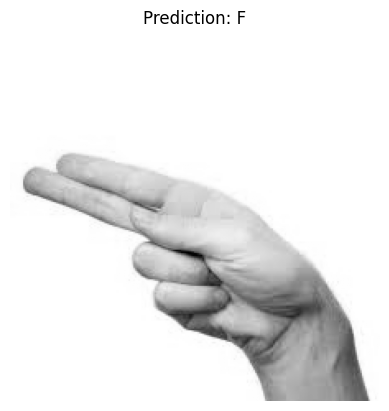

In [28]:

# --- 9. Prediction Function ---
def preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 32, 32, 1)
    return img_array

def predict_asl(img_path):
    print(f"Predicting for image: {img_path}")
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction) # Get the index of the highest probability
    predicted_label = class_labels[class_index] # Map index to class label
    confidence = np.max(prediction) # Get the confidence (highest probability)

    print(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")

    # Show the image
    plt.imshow(image.load_img(img_path, color_mode='grayscale'), cmap='gray')
    plt.axis('off') # Hide axes
    plt.title(f"Prediction: {predicted_label}") # Set title to predicted label
    plt.show()

predict_asl(r"C:\Users\ramch\Downloads\H.jpg")
# predict_asl(r"C:\Users\ramch\Downloads\AA.jpg") # User's original example path - uncomment and update if needed


In [ ]:

# --- 10. Save Final Model ---
# Saves the entire model (architecture, weights, optimizer state)
print("Saving the final model...")
model.save("asl_alphabet_FCN_model.keras")
print("Model saved as asl_alphabet_final_model.keras")


Saving the final model...
Model saved as asl_alphabet_final_model.keras
